# SVM Model Iteration Overview
This notebook contains multiple SVM model development iterations for the RF signal classification task.
Each iteration represents a distinct experimental configuration and follows a consistent workflow to ensure comparability of results.

For every iteration, the following steps are performed:
	1.	Data Cleaning – Load and preprocess the dataset, normalize inputs, and apply balancing if required.
	2.	Model Design / Building – Define the specific configuration for the iteration (e.g., raw pixels, PCA, HOG, ensembles, kernel type).
	3.	Model Training – Fit the model to the prepared training dataset using the defined configuration.
	4.	Model Optimization – Tune hyperparameters, adjust feature extraction methods, or refine the pipeline to improve performance.
	5.	Model Analysis – Evaluate model performance using accuracy, precision, recall, and F1-score; generate confusion matrices; and compare results against previous iterations.

Iteration Summaries:
	•	Iteration 1: Proof-of-concept SVM using a small subset of categories to validate the pipeline.
	•	Iteration 2: Full dataset SVM (imbalanced) to assess raw performance across all classes.
	•	Iteration 3: Balanced dataset SVM to improve fairness and macro metrics.
	•	Iteration 4: Top-5 frequent categories using raw pixel features.
	•	Iteration 5: Top-5 categories with PCA-reduced features.
	•	Iteration 6: PCA-reduced features with RBF kernel for non-linear separation.
	•	Iteration 7: Combined PCA + HOG features in a single SVM.
	•	Iteration 8: Ensemble of PCA-SVM and HOG-SVM with averaged predictions.
	•	Iteration 9: Soft Voting Ensemble (PCA-SVM + HOG-SVM) on top-5 categories.
	•	Iteration 10: Soft Voting Ensemble (PCA-SVM + HOG-SVM) on the full dataset.

By structuring all iterations in this manner, the experimental process remains transparent, reproducible, and easy to analyze across varying approaches.


# Global Settings

In [75]:
# Path
base_dir = "/Users/bilalnajar/PycharmProjects/capstone/waterfall"  # BASE DIRECTORY TO BE CHANGED


# Imports
import os
import random
import warnings

import cv2
import numpy as np
import pandas as pd

from collections import defaultdict, Counter
from itertools import islice

# ML / metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_score, recall_score
)

# Feature extractors
from skimage.feature import hog

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Time elapsed
import time
from contextlib import contextmanager

@contextmanager
def timer(label="Elapsed"):
    t0 = time.perf_counter()
    try:
        yield
    finally:
        dt = time.perf_counter() - t0
        print(f"{label}: {dt:.2f} s")

# Deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
    from tensorflow.keras.utils import to_categorical
except Exception:
    tf = None  


# Iteration 1: Proof-of-concept SVM using a small subset of categories to validate the pipeline.

In [76]:
# Define image size
img_size = 64

# Define selected categories for proof of concept
selected_categories = [
    "fm",
    "bluetooth",
    "digital-audio-broadcasting",
    "z-wave",
    "RS41-Radiosonde"
]

# Load only selected categories
images = []
labels = []

for category in selected_categories:
    category_path = os.path.join(base_dir, category)
    if not os.path.isdir(category_path):
        print(f"Skipping missing category: {category}")
        continue

    for img_name in os.listdir(category_path):
        try:
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img.flatten())
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_name} from {category}: {e}")
            
# Proceed with training if any images were loaded
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    X = np.array(images)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=27
    )

    # Train SVM
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_model.fit(X_train, y_train)

    # Evaluate
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

else:
    print("Image loading failed or no images found.")

Classification Report:
                             precision    recall  f1-score   support

           RS41-Radiosonde       0.68      0.47      0.56        55
                 bluetooth       0.77      0.64      0.70        42
digital-audio-broadcasting       1.00      1.00      1.00        13
                        fm       0.73      0.91      0.81       148
                    z-wave       0.67      0.49      0.56        41

                  accuracy                           0.74       299
                 macro avg       0.77      0.70      0.73       299
              weighted avg       0.73      0.74      0.72       299

Confusion Matrix:
 [[ 26   3   0  26   0]
 [  7  27   0   8   0]
 [  0   0  13   0   0]
 [  3   1   0 134  10]
 [  2   4   0  15  20]]


| Class                      | Precision | Recall | F1   | Notes                                      |
|---------------------------|-----------|--------|------|--------------------------------------------|
| RS41-Radiosonde           | 0.68      | 0.47   | 0.56 | Misclassified heavily as fm                |
| bluetooth                 | 0.77      | 0.64   | 0.70 | Some overlap with fm, but good overall     |
| digital-audio-broadcasting| 1.00      | 1.00   | 1.00 | Perfect separation — very distinctive      |
| fm                        | 0.73      | 0.91   | 0.81 | Strong performance — well represented      |
| z-wave                    | 0.67      | 0.49   | 0.56 | Often confused with fm                     |

# Iteration 2: Full dataset SVM (imbalanced) to assess raw performance across all classes.

In [77]:
# Define Image size
img_size = 64

# Dynamically discover all categories in the base directory (excluding 'unknown')
all_categories = [
    category for category in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, category)) and category.lower() != "unknown"
]

# Collect image paths by category
from collections import defaultdict

category_images = defaultdict(list)
for category in all_categories:
    category_path = os.path.join(base_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        category_images[category].append(img_path)

# Determine the minimum sample size available among all categories
# Filter out tiny classes
min_required = 5
category_images = {k: v for k, v in category_images.items() if len(v) >= min_required}
min_samples = min(len(paths) for paths in category_images.values())

# Load and preprocess balanced dataset
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths[:min_samples]:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img.flatten())
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Proceed with training if any images were loaded
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    X = np.array(images)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=27
    )

    # Train SVM
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_model.fit(X_train, y_train)

    # Evaluate
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

else:
    print("Image loading failed or no images found.")


Classification Report:
                                 precision    recall  f1-score   support

                         16QAM       0.00      0.00      0.00         1
                          2ASK       0.00      0.00      0.00         1
                         32QAM       1.00      1.00      1.00         1
                          4FSK       0.00      0.00      0.00         1
                          8PSK       0.00      0.00      0.00         1
               RS41-Radiosonde       0.00      0.00      0.00         1
                 Radioteletype       0.00      0.00      0.00         1
                         ads-b       0.00      0.00      0.00         1
                       airband       0.00      0.00      0.00         1
                           ais       0.00      0.00      0.00         1
                            am       0.00      0.00      0.00         1
                          atsc       0.00      0.00      0.00         1
automatic-picture-transmission       0.

/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

# Iteration 3: Balanced dataset SVM to improve fairness and macro metrics. (Filtering out all cateogies with less than 50 samples)

In [78]:
# Define image size
img_size = 64

# Dynamically discover all categories in the base directory (excluding 'unknown')
all_categories = [
    category for category in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, category)) and category.lower() != "unknown"
]

# Collect image paths by category
from collections import defaultdict

category_images = defaultdict(list)
for category in all_categories:
    category_path = os.path.join(base_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        category_images[category].append(img_path)

# Determine the minimum sample size available among all categories
# Filter out tiny classes
min_required = 50
category_images = {k: v for k, v in category_images.items() if len(v) >= min_required}
min_samples = min(len(paths) for paths in category_images.values())

# Load and preprocess balanced dataset
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths[:min_samples]:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img.flatten())
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Proceed with training if any images were loaded
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    X = np.array(images)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=27
    )

    # Train SVM
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_model.fit(X_train, y_train)

    # Evaluate
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

else:
    print("Image loading failed or no images found.")


Classification Report:
                             precision    recall  f1-score   support

           RS41-Radiosonde       0.27      0.30      0.29        10
                   airband       0.40      0.20      0.27        10
                       ais       0.75      0.60      0.67        10
                 bluetooth       0.33      0.10      0.15        10
                  cellular       0.00      0.00      0.00        10
digital-audio-broadcasting       0.90      0.90      0.90        10
    digital-speech-decoder       0.71      0.50      0.59        10
                        fm       0.19      0.50      0.27        10
                      lora       0.19      0.30      0.23        10
                    packet       0.18      0.40      0.25        10
      remote-keyless-entry       0.00      0.00      0.00        10
                      sstv       0.14      0.10      0.12        10
                       vor       0.50      0.80      0.62        10
                      w

/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

# Iteration 4: Top-5 frequent categories using raw pixel features.

In [79]:
#Define image size
img_size = 64

# Show and select top categories by sample size
from collections import defaultdict

# Collect image paths by category
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if not os.path.isdir(category_path) or category.lower() == "unknown":
        continue
    for img_name in os.listdir(category_path):
        category_images[category].append(os.path.join(category_path, img_name))

# Sort categories by number of available images
sorted_categories = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)

# Select the top N categories with the most images
top_n = 5
selected_categories = [cat for cat, paths in sorted_categories[:top_n]]
print("Using categories:", selected_categories)

# Limit each selected category to a fixed number of samples
limit_per_class = 50
category_images = {
    cat: paths[:limit_per_class] for cat, paths in category_images.items() if cat in selected_categories
}

# Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img.flatten())
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Proceed with training if any images were loaded
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    X = np.array(images)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=27
    )

    # Train SVM
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_model.fit(X_train, y_train)

    # Evaluate
    y_pred = svm_model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)

else:
    print("Image loading failed or no images found.")



Using categories: ['fm', 'lora', 'cellular', 'packet', 'wifi']
Classification Report:
               precision    recall  f1-score   support

    cellular       0.50      0.10      0.17        10
          fm       0.33      0.80      0.47        10
        lora       0.29      0.20      0.24        10
      packet       0.43      0.60      0.50        10
        wifi       0.33      0.10      0.15        10

    accuracy                           0.36        50
   macro avg       0.38      0.36      0.31        50
weighted avg       0.38      0.36      0.31        50

Confusion Matrix:
 [[1 4 2 2 1]
 [0 8 2 0 0]
 [0 4 2 3 1]
 [1 2 1 6 0]
 [0 6 0 3 1]]


# Iteration 5: Top-5 categories with PCA-reduced features

In [80]:
# Set parameters 
img_size = 64
top_n = 5
limit_per_class = 50

# Step 1: Load image paths by category
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path) and category.lower() != "unknown":
        for img_name in os.listdir(category_path):
            category_images[category].append(os.path.join(category_path, img_name))

# Step 2: Select top 5 categories with the most images
sorted_categories = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)
selected_categories = [cat for cat, paths in sorted_categories[:top_n]]
print("Using categories:", selected_categories)

# Step 3: Limit each selected class to 5 samples
category_images = {
    cat: paths[:limit_per_class] for cat, paths in category_images.items() if cat in selected_categories
}

# Step 4: Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img.flatten())
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Step 5: Prepare features and labels
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    X = np.array(images)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 6: Apply PCA for dimensionality reduction
    pca = PCA(n_components=100)
    X_pca = pca.fit_transform(X_scaled)

    # Step 7: Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, stratify=y, random_state=27
    )

    # Step 8: Hyperparameter tuning with class_weight='balanced'
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }

    grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3)
    grid.fit(X_train, y_train)

    # Step 9: Evaluate model
    y_pred = grid.predict(X_test)
    print("Best Parameters:", grid.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("Image loading failed or no images found.")

Using categories: ['fm', 'lora', 'cellular', 'packet', 'wifi']
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

    cellular       0.38      0.50      0.43        10
          fm       0.41      0.70      0.52        10
        lora       0.33      0.20      0.25        10
      packet       0.33      0.30      0.32        10
        wifi       0.60      0.30      0.40        10

    accuracy                           0.40        50
   macro avg       0.41      0.40      0.38        50
weighted avg       0.41      0.40      0.38        50

Confusion Matrix:
 [[5 2 2 1 0]
 [1 7 1 1 0]
 [0 5 2 1 2]
 [5 2 0 3 0]
 [2 1 1 3 3]]


# Iteration 6: PCA-reduced features with RBF kernel for non-linear separation

In [81]:
# Set parameters
img_size = 64
top_n = 5
limit_per_class = 50

# Step 1: Load image paths by category
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path) and category.lower() != "unknown":
        for img_name in os.listdir(category_path):
            category_images[category].append(os.path.join(category_path, img_name))

# Step 2: Select top 5 categories with the most images
sorted_categories = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)
selected_categories = [cat for cat, paths in sorted_categories[:top_n]]
print("Using categories:", selected_categories)

# Step 3: Limit each selected class to 50 samples
category_images = {
    cat: paths[:limit_per_class] for cat, paths in category_images.items() if cat in selected_categories
}

# Step 4: Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Step 5: Prepare features and labels
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    # Extract HOG features
    def extract_hog_features(images, img_size):
        return np.array([
            hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
            for img in images
        ])

    X = extract_hog_features(images, img_size)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=27
    )

    # Step 6: Hyperparameter tuning with class_weight='balanced'
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }

    grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3)
    grid.fit(X_train, y_train)

    # Step 7: Evaluate model
    y_pred = grid.predict(X_test)
    print("Best Parameters:", grid.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("Image loading failed or no images found.")

Using categories: ['fm', 'lora', 'cellular', 'packet', 'wifi']
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

    cellular       0.43      0.60      0.50        10
          fm       0.88      0.70      0.78        10
        lora       0.60      0.60      0.60        10
      packet       0.80      0.80      0.80        10
        wifi       0.50      0.40      0.44        10

    accuracy                           0.62        50
   macro avg       0.64      0.62      0.62        50
weighted avg       0.64      0.62      0.62        50

Confusion Matrix:
 [[6 0 2 0 2]
 [2 7 1 0 0]
 [2 1 6 0 1]
 [1 0 0 8 1]
 [3 0 1 2 4]]


# Iteration 7: Combined PCA + HOG features in a single SVM. HOG with Image Size Increased to 128 x 128 (2x increase)

In [82]:
# Set parameters
img_size = 128
top_n = 5
limit_per_class = 50

# Step 1: Load image paths by category
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path) and category.lower() != "unknown":
        for img_name in os.listdir(category_path):
            category_images[category].append(os.path.join(category_path, img_name))

# Step 2: Select top 5 categories with the most images
sorted_categories = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)
selected_categories = [cat for cat, paths in sorted_categories[:top_n]]
print("Using categories:", selected_categories)

# Step 3: Limit each selected class to 50 samples
category_images = {
    cat: paths[:limit_per_class] for cat, paths in category_images.items() if cat in selected_categories
}

# Step 4: Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Step 5: Prepare features and labels
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    # Extract HOG features
    def extract_hog_features(images, img_size):
        return np.array([
            hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
            for img in images
        ])

    X = extract_hog_features(images, img_size)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=27
    )

    # Step 6: Hyperparameter tuning with class_weight='balanced'
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }

    grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3)
    grid.fit(X_train, y_train)

    # Step 7: Evaluate model
    y_pred = grid.predict(X_test)
    print("Best Parameters:", grid.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
else:
    print("Image loading failed or no images found.")

Using categories: ['fm', 'lora', 'cellular', 'packet', 'wifi']
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

    cellular       0.64      0.70      0.67        10
          fm       0.75      0.60      0.67        10
        lora       1.00      0.70      0.82        10
      packet       0.73      0.80      0.76        10
        wifi       0.77      1.00      0.87        10

    accuracy                           0.76        50
   macro avg       0.78      0.76      0.76        50
weighted avg       0.78      0.76      0.76        50

Confusion Matrix:
 [[ 7  0  0  1  2]
 [ 2  6  0  2  0]
 [ 0  2  7  0  1]
 [ 2  0  0  8  0]
 [ 0  0  0  0 10]]


# Iteration 8: Ensemble of PCA-SVM and HOG-SVM with averaged predictions. Ensemble of PCA + HOG with Voting with 128 x 128 image size

In [83]:
# Set parameters
img_size = 128
top_n = 5
limit_per_class = 50

# Step 1: Load image paths by category
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path) and category.lower() != "unknown":
        for img_name in os.listdir(category_path):
            category_images[category].append(os.path.join(category_path, img_name))

# Step 2: Select top N categories
sorted_categories = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)
selected_categories = [cat for cat, paths in sorted_categories[:top_n]]
print("Using categories:", selected_categories)

# Step 3: Limit per class
category_images = {
    cat: paths[:limit_per_class] for cat, paths in category_images.items() if cat in selected_categories
}

# Step 4: Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Step 5: Prepare labels and scale
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    images = np.array(images)
    flat_images = images.reshape(len(images), -1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(flat_images)

    # Step 6: Extract PCA features
    pca = PCA(n_components=100)
    X_pca = pca.fit_transform(X_scaled)

    # Step 7: Extract HOG features
    def extract_hog_features(images, img_size):
        return np.array([
            hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
            for img in images
        ])
    X_hog = extract_hog_features(images, img_size)

    # Step 8: Train/test split (same split for both models)
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, stratify=y, random_state=27
    )
    X_train_hog, X_test_hog, _, _ = train_test_split(
        X_hog, y, test_size=0.2, stratify=y, random_state=27
    )

    # Step 9: Train both SVM models with best known parameters
    svm_pca = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced')
    svm_hog = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced')

    svm_pca.fit(X_train_pca, y_train)
    svm_hog.fit(X_train_hog, y_train)

    # Step 10: Predict from both
    y_pred_pca = svm_pca.predict(X_test_pca)
    y_pred_hog = svm_hog.predict(X_test_hog)

    # Step 11: Majority voting
    y_pred_ensemble = mode(np.vstack((y_pred_pca, y_pred_hog)), axis=0).mode.flatten()

    # Step 12: Evaluate
    print("Ensemble Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names=le.classes_))
    print("Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))

else:
    print("Image loading failed or no images found.")

Using categories: ['fm', 'lora', 'cellular', 'packet', 'wifi']
Ensemble Classification Report:
               precision    recall  f1-score   support

    cellular       0.50      1.00      0.67        10
          fm       0.80      0.80      0.80        10
        lora       0.62      0.50      0.56        10
      packet       0.88      0.70      0.78        10
        wifi       1.00      0.40      0.57        10

    accuracy                           0.68        50
   macro avg       0.76      0.68      0.67        50
weighted avg       0.76      0.68      0.67        50

Ensemble Confusion Matrix:
 [[10  0  0  0  0]
 [ 1  8  1  0  0]
 [ 3  2  5  0  0]
 [ 2  0  1  7  0]
 [ 4  0  1  1  4]]


# Iteration 9: Soft Voting Ensemble (PCA-SVM + HOG-SVM) on top-5 categories.

In [84]:
# Set parameters
img_size = 128
top_n = 5
limit_per_class = 50

# Step 1: Load image paths
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path) and category.lower() != "unknown":
        for img_name in os.listdir(category_path):
            category_images[category].append(os.path.join(category_path, img_name))

# Step 2: Select top 5 categories
sorted_categories = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)
selected_categories = [cat for cat, paths in sorted_categories[:top_n]]
print("Using categories:", selected_categories)

# Step 3: Limit per class
category_images = {
    cat: paths[:limit_per_class] for cat, paths in category_images.items() if cat in selected_categories
}

# Step 4: Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Step 5: Prepare labels
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    images = np.array(images)
    flat_images = images.reshape(len(images), -1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(flat_images)

    # Step 6: PCA features
    pca = PCA(n_components=100)
    X_pca = pca.fit_transform(X_scaled)

    # Step 7: HOG features
    def extract_hog_features(images, img_size):
        return np.array([
            hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
            for img in images
        ])
    X_hog = extract_hog_features(images, img_size)

    # Step 8: Train/test split
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, stratify=y, random_state=27
    )
    X_train_hog, X_test_hog, _, _ = train_test_split(
        X_hog, y, test_size=0.2, stratify=y, random_state=27
    )

    # Step 9: Use SVC with probability=True
    svm_pca = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced', probability=True)
    svm_hog = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced', probability=True)

    svm_pca.fit(X_train_pca, y_train)
    svm_hog.fit(X_train_hog, y_train)

    # Step 10: Predict probabilities
    probs_pca = svm_pca.predict_proba(X_test_pca)
    probs_hog = svm_hog.predict_proba(X_test_hog)

    # Step 11: Average probabilities (soft voting)
    avg_probs = (probs_pca + probs_hog) / 2
    y_pred_ensemble = np.argmax(avg_probs, axis=1)

    # Step 12: Evaluate
    print("Soft Voting Ensemble Classification Report:\n", classification_report(y_test, y_pred_ensemble, target_names=le.classes_))
    print("Soft Voting Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))

else:
    print("Image loading failed or no images found.")

Using categories: ['fm', 'lora', 'cellular', 'packet', 'wifi']
Soft Voting Ensemble Classification Report:
               precision    recall  f1-score   support

    cellular       0.73      0.80      0.76        10
          fm       0.64      0.70      0.67        10
        lora       0.71      0.50      0.59        10
      packet       0.82      0.90      0.86        10
        wifi       0.80      0.80      0.80        10

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.73        50
weighted avg       0.74      0.74      0.73        50

Soft Voting Ensemble Confusion Matrix:
 [[8 0 1 0 1]
 [0 7 1 2 0]
 [1 4 5 0 0]
 [0 0 0 9 1]
 [2 0 0 0 8]]


# Iteration 10: Soft Voting Ensemble (PCA-SVM + HOG-SVM) on the full dataset.

In [85]:
# Set parameters
img_size = 128
min_samples_required = 5

# Step 1: Load image paths by category
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path) and category.lower() != "unknown":
        for img_name in os.listdir(category_path):
            category_images[category].append(os.path.join(category_path, img_name))

# Step 2: Filter categories with at least `5` images
category_images = {k: v for k, v in category_images.items() if len(v) >= min_samples_required}

# Step 3: Limit per class to `5`
category_images = {k: v[:min_samples_required] for k, v in category_images.items()}

# Step 4: Load and preprocess images
images = []
labels = []
for category, paths in category_images.items():
    for img_path in paths:
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(category)
        except Exception as e:
            print(f"Error loading image {img_path} from {category}: {e}")

# Step 5: Prepare labels and scale
if images:
    le = LabelEncoder()
    y = le.fit_transform(labels)

    images = np.array(images)
    flat_images = images.reshape(len(images), -1)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(flat_images)

    # Step 6: PCA features (limit components to min of samples or features)
    max_components = min(len(images), X_scaled.shape[1], 100)
    pca = PCA(n_components=max_components)
    X_pca = pca.fit_transform(X_scaled)


    # Step 7: HOG features
    def extract_hog_features(images, img_size):
        return np.array([
            hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
            for img in images
        ])


    X_hog = extract_hog_features(images, img_size)

    # Step 8: Train/test split
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.2, stratify=y, random_state=27
    )
    X_train_hog, X_test_hog, _, _ = train_test_split(
        X_hog, y, test_size=0.2, stratify=y, random_state=27
    )

    with timer("SVM (PCA+HOG) train+predict"):
       
        # Step 9: Train SVC models with probability=True
        svm_pca = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced', probability=True)
        svm_hog = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced', probability=True)
    
        svm_pca.fit(X_train_pca, y_train)
        svm_hog.fit(X_train_hog, y_train)
    
        # Step 10: Predict probabilities
        probs_pca = svm_pca.predict_proba(X_test_pca)
        probs_hog = svm_hog.predict_proba(X_test_hog)
    
        # Step 11: Average probabilities (soft voting)
        avg_probs = (probs_pca + probs_hog) / 2
        y_pred_ensemble = np.argmax(avg_probs, axis=1)

    # Step 12: Evaluate
    print("Soft Voting Ensemble Classification Report:\n",
          classification_report(y_test, y_pred_ensemble, target_names=le.classes_))
    print("Soft Voting Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
else:
    print("Image loading failed or no images found.")

SVM (PCA+HOG) train+predict: 0.12 s
Soft Voting Ensemble Classification Report:
                                 precision    recall  f1-score   support

                         16QAM       0.00      0.00      0.00         1
                          2ASK       0.00      0.00      0.00         1
                         32QAM       0.00      0.00      0.00         1
                          4FSK       0.00      0.00      0.00         1
                          8PSK       1.00      1.00      1.00         1
               RS41-Radiosonde       0.50      1.00      0.67         1
                 Radioteletype       1.00      1.00      1.00         1
                         ads-b       0.00      0.00      0.00         1
                       airband       1.00      1.00      1.00         1
                           ais       1.00      1.00      1.00         1
                            am       0.00      0.00      0.00         1
                          atsc       0.00      0.00   

/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/Users/bilalnaj

# Iteration 10 (Part 2) Dropoff Matrix to Determine Optimal Sample Parameters

/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/Users/bilalnajar/PycharmProjects/capstone/venv/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/Users/bilalnaj

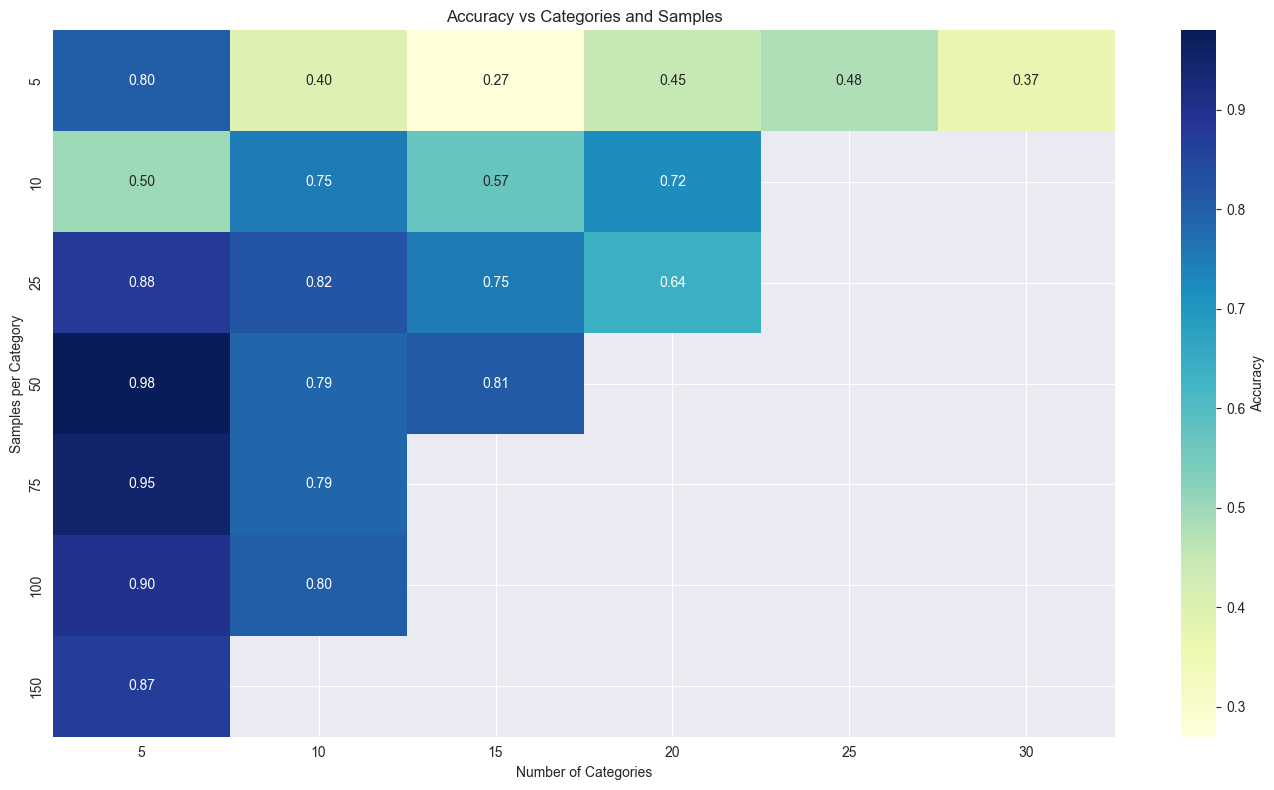

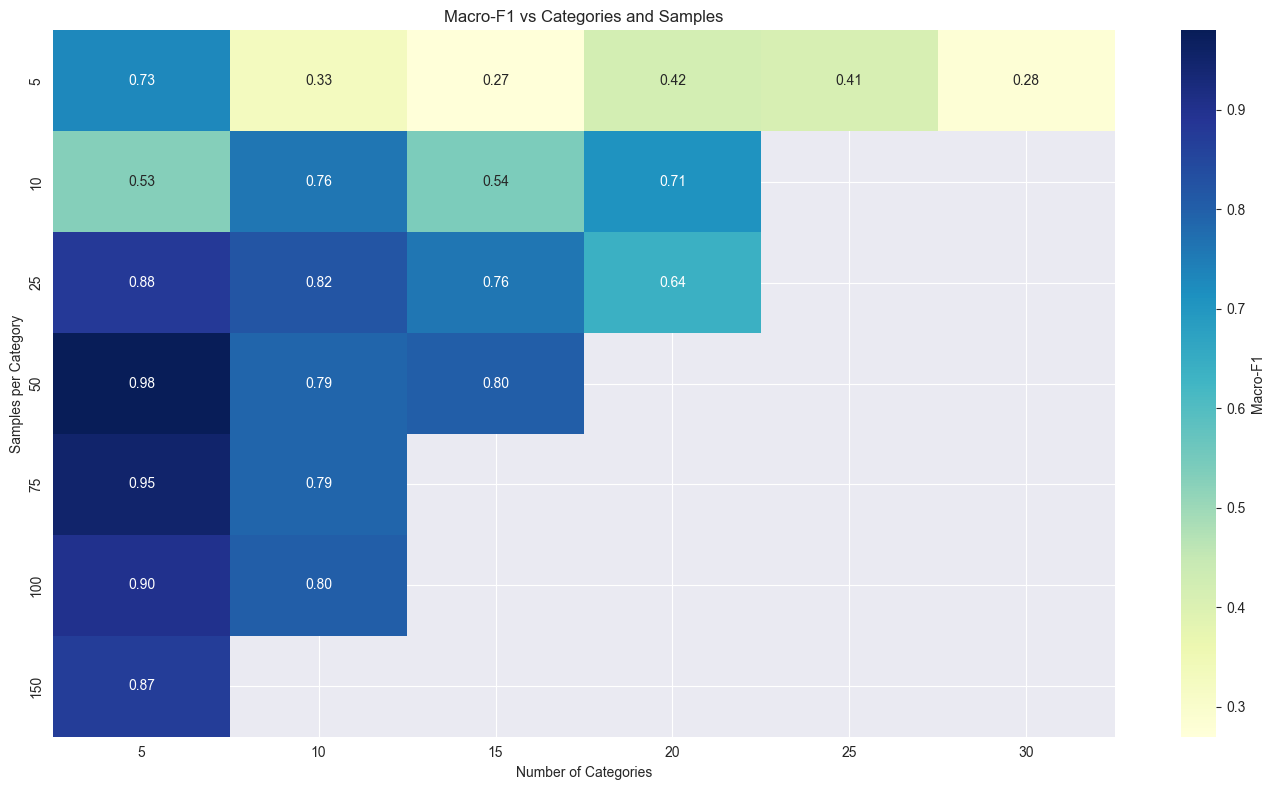

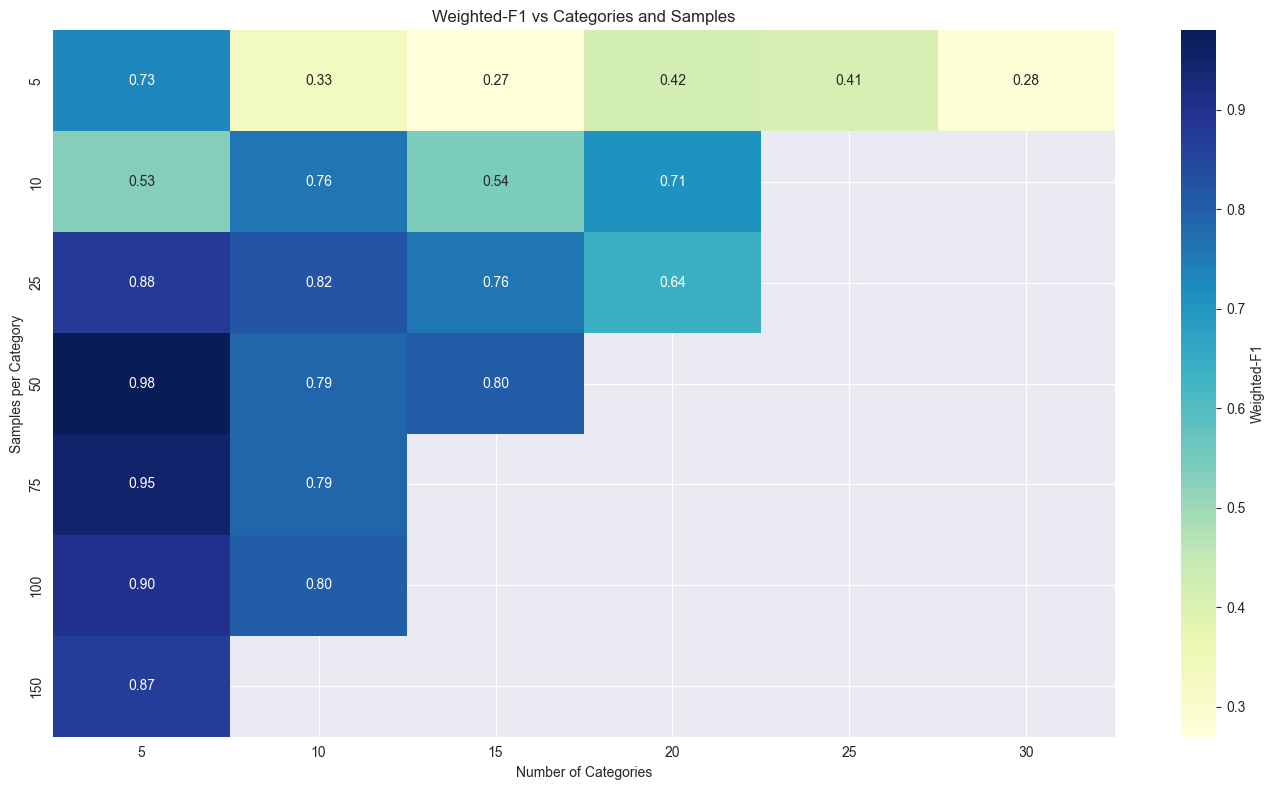

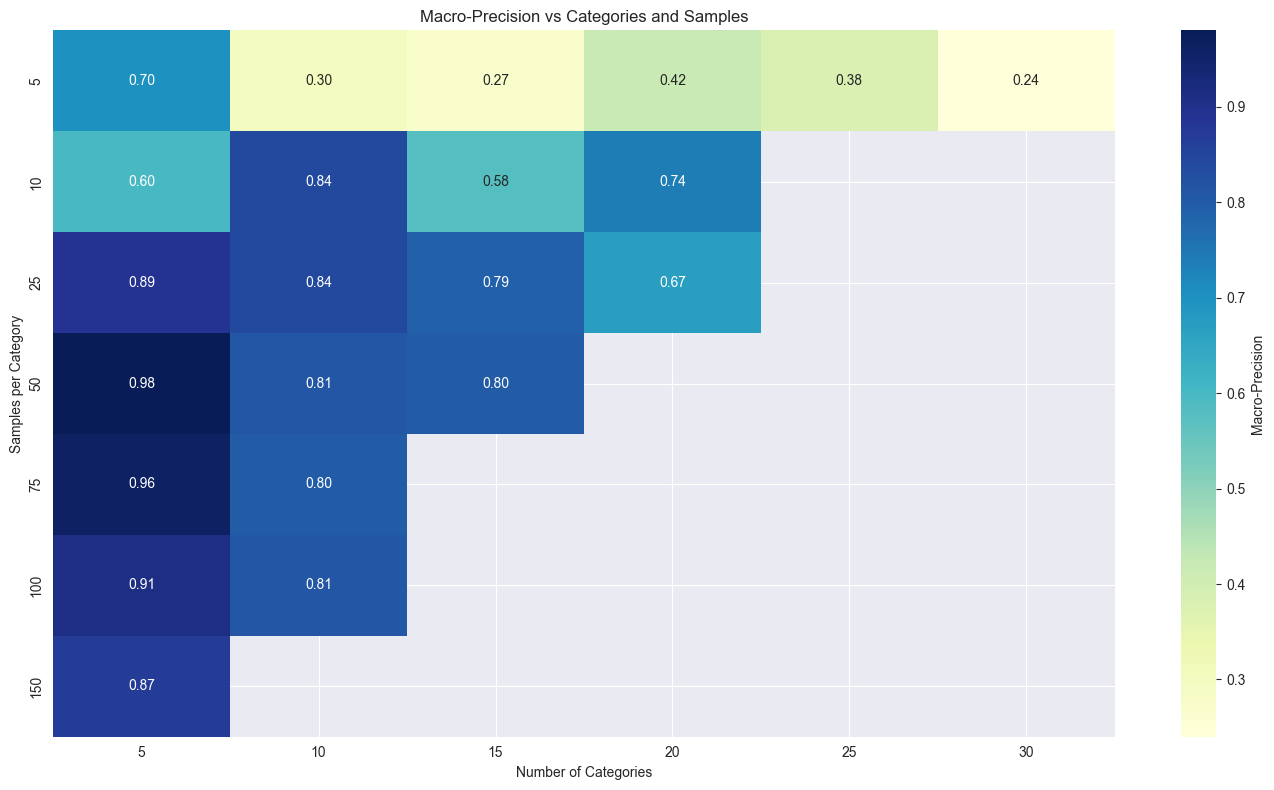

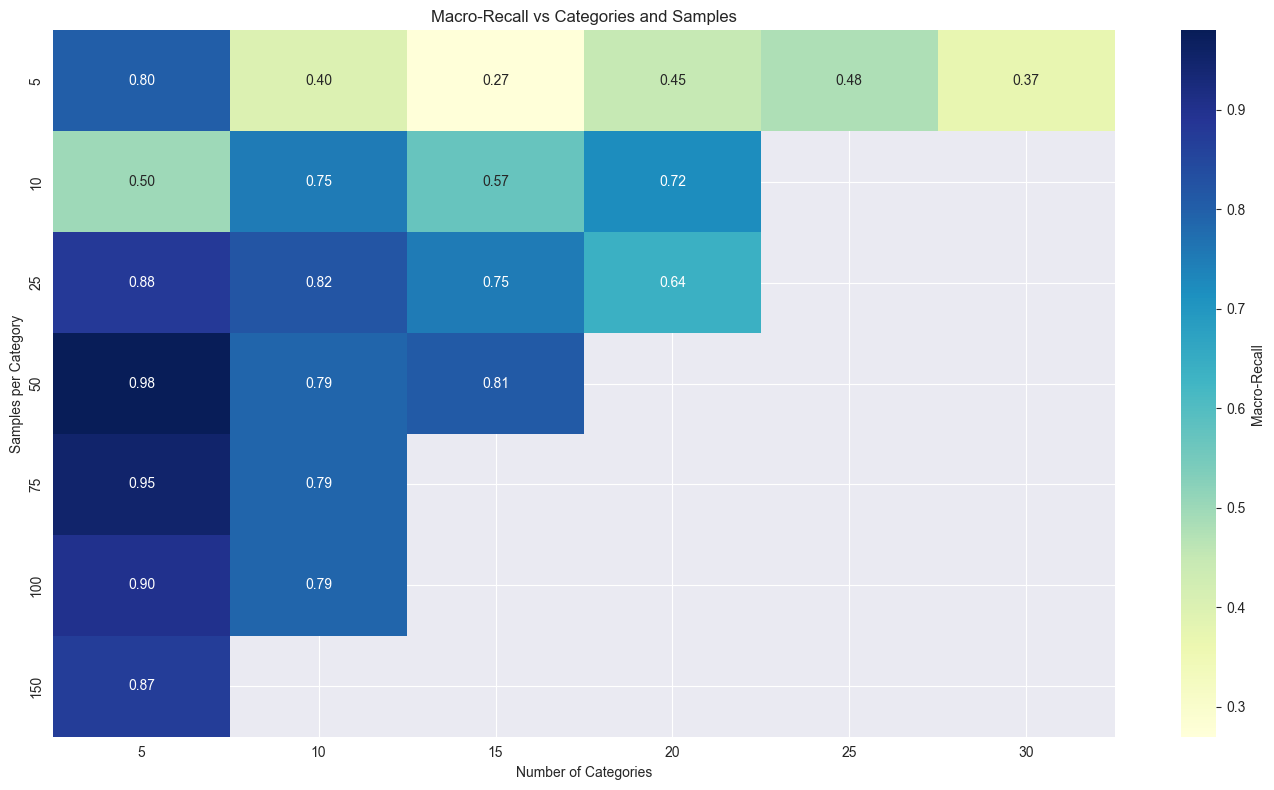

In [86]:
# Set Parameters
img_size = 128
min_samples = 5  # minimum required per category to be eligible
sample_counts = [5, 10, 25, 50, 75, 100, 150]
category_counts = list(range(5, 31, 5))  # up to 30 categories in steps of 5


# Load all eligible categories
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    if category.lower() == "unknown":
        continue
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        imgs = [os.path.join(category_path, fname) for fname in os.listdir(category_path)]
        if len(imgs) >= min_samples:
            category_images[category] = imgs


# Results matrices (DataFrames)
acc_matrix = pd.DataFrame(index=sample_counts, columns=category_counts, dtype=float)
macro_f1_matrix = pd.DataFrame(index=sample_counts, columns=category_counts, dtype=float)
weighted_f1_matrix = pd.DataFrame(index=sample_counts, columns=category_counts, dtype=float)
macro_precision_matrix = pd.DataFrame(index=sample_counts, columns=category_counts, dtype=float)
macro_recall_matrix = pd.DataFrame(index=sample_counts, columns=category_counts, dtype=float)


# Helper: HOG Feature Extractor
def extract_hog_features(images):
    return np.array([
        hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        for img in images
    ])


# Dropoff Evaluation
for num_samples in sample_counts:
    # Categories that can supply at least `num_samples`
    eligible_cats = [cat for cat, imgs in category_images.items() if len(imgs) >= num_samples]

    for num_categories in category_counts:
        if num_categories > len(eligible_cats):
            continue  # skip if not enough categories

        selected_cats = eligible_cats[:num_categories]

        images, labels = [], []
        for cat in selected_cats:
            for img_path in category_images[cat][:num_samples]:
                try:
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (img_size, img_size))
                    images.append(img)
                    labels.append(cat)
                except Exception:
                    pass

        if not images:
            continue

        X_images = np.array(images)
        le = LabelEncoder()
        y = le.fit_transform(labels)

        # PCA branch (on flattened, scaled pixels)
        flat = X_images.reshape(len(X_images), -1)
        scaler_flat = StandardScaler()
        X_scaled = scaler_flat.fit_transform(flat)

        pca_components = max(2, min(100, X_scaled.shape[0], X_scaled.shape[1]))
        X_pca = PCA(n_components=pca_components).fit_transform(X_scaled)

        # HOG branch
        X_hog = extract_hog_features(X_images)
        scaler_hog = StandardScaler()
        X_hog_scaled = scaler_hog.fit_transform(X_hog)

        # Same split for both branches
        X_train_pca, X_test_pca, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, stratify=y, random_state=27
        )
        X_train_hog, X_test_hog, _, _ = train_test_split(
            X_hog_scaled, y, test_size=0.2, stratify=y, random_state=27
        )

        # Models
        svm_pca = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced', probability=True)
        svm_hog = SVC(C=10, gamma='scale', kernel='rbf', class_weight='balanced', probability=True)
        svm_pca.fit(X_train_pca, y_train)
        svm_hog.fit(X_train_hog, y_train)

        # Soft Voting
        probs_pca = svm_pca.predict_proba(X_test_pca)
        probs_hog = svm_hog.predict_proba(X_test_hog)
        avg_probs = (probs_pca + probs_hog) / 2.0
        y_pred = np.argmax(avg_probs, axis=1)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        macro_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        macro_rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

        acc_matrix.loc[num_samples, num_categories] = round(acc, 2)
        macro_f1_matrix.loc[num_samples, num_categories] = round(macro_f1, 2)
        weighted_f1_matrix.loc[num_samples, num_categories] = round(weighted_f1, 2)
        macro_precision_matrix.loc[num_samples, num_categories] = round(macro_prec, 2)
        macro_recall_matrix.loc[num_samples, num_categories] = round(macro_rec, 2)


# Heatmap Visualization
def plot_heatmap(df, title):
    plt.figure(figsize=(14, 8))
    sns.heatmap(df.astype(float), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': title.split()[0]})
    plt.title(title)
    plt.xlabel("Number of Categories")
    plt.ylabel("Samples per Category")
    plt.tight_layout()
    plt.show()

plot_heatmap(acc_matrix, "Accuracy vs Categories and Samples")
plot_heatmap(macro_f1_matrix, "Macro-F1 vs Categories and Samples")
plot_heatmap(weighted_f1_matrix, "Weighted-F1 vs Categories and Samples")

#Plot macro precision/recall:
plot_heatmap(macro_precision_matrix, "Macro-Precision vs Categories and Samples")
plot_heatmap(macro_recall_matrix, "Macro-Recall vs Categories and Samples")



# Compare Baseline CNN vs SVM (same data & split) 

Selected Categories: ['fm', 'lora', 'cellular', 'packet', 'wifi', 'RS41-Radiosonde', 'bluetooth', 'z-wave', 'remote-keyless-entry', 'ais', 'sstv', 'vor', 'airband', 'digital-audio-broadcasting', 'digital-speech-decoder']
Total samples: 750  |  Classes: 15


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,679 (28.20 MB)

 Trainable params: 7,393,679 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.1075 - loss: 2.8736 - val_accuracy: 0.2400 - val_loss: 2.5469
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.2041 - loss: 2.4963 - val_accuracy: 0.3000 - val_loss: 2.2929
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3101 - loss: 2.2622 - val_accuracy: 0.3533 - val_loss: 2.0330
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4029 - loss: 1.9707 - val_accuracy: 0.4267 - val_loss: 1.8717
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5084 - loss: 1.7436 - val_accuracy: 0.5533 - val_loss: 1.7334
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5504 - loss: 1.5811 - val_accuracy: 0.5400 - val_loss: 1.6946
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5751 - loss: 1.4179 - val_accuracy: 0.6133 - val_loss: 1.4809
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6408 - loss: 1.2346 - val_accuracy: 0.5933 - v

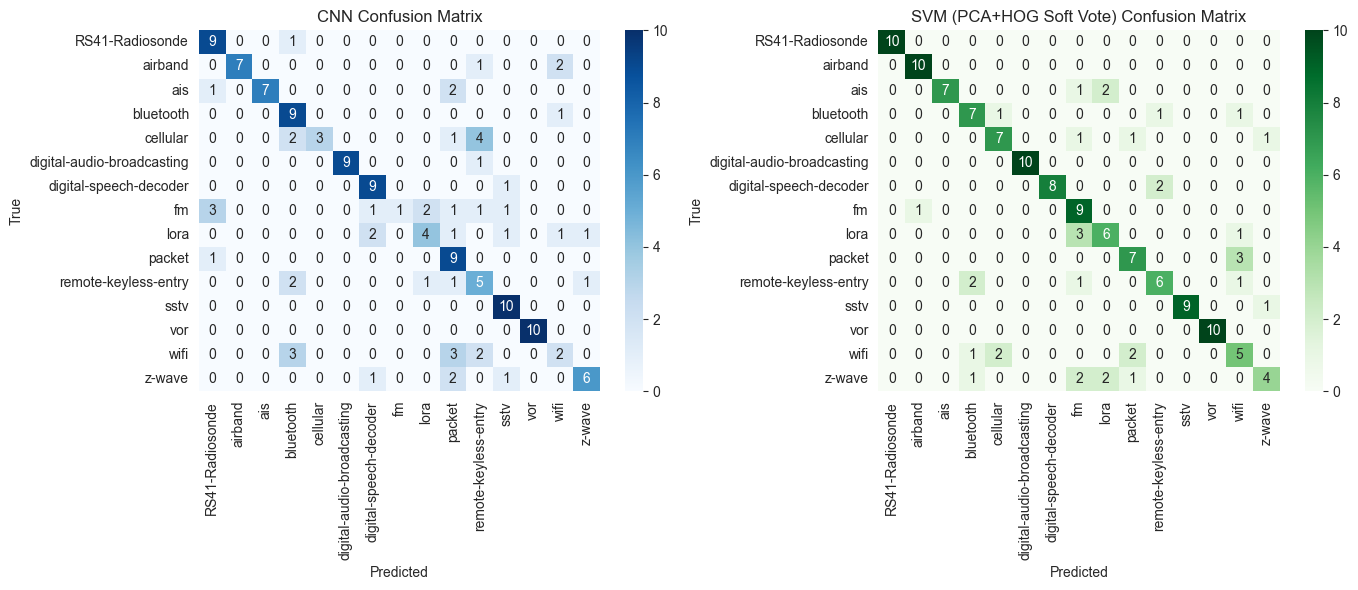

Comparison (same data & split)
CNN Accuracy:           0.667
SVM (PCA+HOG) Accuracy: 0.767


In [87]:
import os, random, time
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from skimage.feature import hog
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

random.seed(27)
np.random.seed(27)
tf.random.set_seed(27)

# Parameters
img_size = 128
top_n = 15
samples_per_class = 50

# Gather images
category_images = defaultdict(list)
for category in os.listdir(base_dir):
    path = os.path.join(base_dir, category)
    if os.path.isdir(path) and category.lower() != "unknown":
        files = [os.path.join(path, f) for f in os.listdir(path)]
        if len(files) >= samples_per_class:
            category_images[category] = files

# Sort by availability and pick top_n categories
sorted_cats = sorted(category_images.items(), key=lambda x: len(x[1]), reverse=True)[:top_n]
selected_categories = [c for c, _ in sorted_cats]
print("Selected Categories:", selected_categories)

# Deterministic per-class sampling
images_gray, labels = [], []
for cat, paths in sorted_cats:
    paths = sorted(paths)
    rng = random.Random(27)
    rng.shuffle(paths)
    subset = paths[:samples_per_class]
    for p in subset:
        try:
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            images_gray.append(img)
            labels.append(cat)
        except Exception as e:
            print(f"Failed loading {p}: {e}")

if not images_gray:
    raise RuntimeError("No images loaded. Check base_dir/top_n/samples_per_class.")

images_gray = np.array(images_gray)                       
le = LabelEncoder()
y_int = le.fit_transform(labels)                         
num_classes = len(le.classes_)
print(f"Total samples: {len(images_gray)}  |  Classes: {num_classes}")

# Shared split indices (so CNN and SVM use the exact same split)
indices = np.arange(len(images_gray))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=y_int, random_state=27
)

# CNN branch
# Prepare CNN tensors
X_cnn = images_gray[..., None] / 255.0 
y_cat = to_categorical(y_int, num_classes=num_classes)    

X_train_cnn, X_test_cnn = X_cnn[train_idx], X_cnn[test_idx]
y_train_cat, y_test_cat   = y_cat[train_idx], y_cat[test_idx]
y_test_int_cnn            = y_int[test_idx]               

# Define a compact CNN (grayscale)
cnn = Sequential([
    Input(shape=(img_size, img_size, 1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

with timer("CNN train+eval"):
    history = cnn.fit(
        X_train_cnn, y_train_cat,
        epochs=10, batch_size=16,
        validation_data=(X_test_cnn, y_test_cat),
        verbose=1
    )
    test_loss_cnn, test_acc_cnn = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)

with timer("CNN predict & reports"):
    y_pred_probs = cnn.predict(X_test_cnn, verbose=0)
    y_pred_int_cnn = np.argmax(y_pred_probs, axis=1)
    print(f"\nCNN Test Accuracy: {test_acc_cnn:.2f}\n")
    print("CNN Classification Report:\n",
          classification_report(y_test_int_cnn, y_pred_int_cnn, target_names=le.classes_))
    cm_cnn = confusion_matrix(y_test_int_cnn, y_pred_int_cnn)

# SVM branch
X_train_gray, X_test_gray = images_gray[train_idx], images_gray[test_idx]
y_train_svm,  y_test_svm  = y_int[train_idx], y_int[test_idx]

# PCA 
with timer("SVM PCA: scale & PCA fit_transform(train) / transform(test)"):
    # Flatten and scale
    flat_train = X_train_gray.reshape(len(X_train_gray), -1)
    flat_test  = X_test_gray.reshape(len(X_test_gray), -1)
    scaler_flat = StandardScaler()
    X_train_scaled = scaler_flat.fit_transform(flat_train)
    X_test_scaled  = scaler_flat.transform(flat_test)
    # PCA
    pca_components = max(2, min(100, X_train_scaled.shape[0], X_train_scaled.shape[1]))
    pca = PCA(n_components=pca_components, random_state=27)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

# HOG
def extract_hog_features(imgs):
    return np.array([
        hog(im, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        for im in imgs
    ])

with timer("SVM HOG: HOG fit_transform(train) / transform(test)"):
    X_train_hog = extract_hog_features(X_train_gray)
    X_test_hog  = extract_hog_features(X_test_gray)
    scaler_hog = StandardScaler()
    X_train_hog_sc = scaler_hog.fit_transform(X_train_hog)
    X_test_hog_sc  = scaler_hog.transform(X_test_hog)

# Train SVMs and soft vote
with timer("SVM (PCA+HOG) train+predict"):
    svm_pca = SVC(C=10, kernel='rbf', gamma='scale',
                  class_weight='balanced', probability=True, random_state=27)
    svm_hog = SVC(C=10, kernel='rbf', gamma='scale',
                  class_weight='balanced', probability=True, random_state=27)
    svm_pca.fit(X_train_pca, y_train_svm)
    svm_hog.fit(X_train_hog_sc, y_train_svm)

    probs_pca = svm_pca.predict_proba(X_test_pca)
    probs_hog = svm_hog.predict_proba(X_test_hog_sc)
    avg_probs = (probs_pca + probs_hog) / 2.0
    y_pred_svm = np.argmax(avg_probs, axis=1)

acc_svm = accuracy_score(y_test_svm, y_pred_svm)
print(f"\nSVM (PCA+HOG, soft vote) Test Accuracy: {acc_svm:.2f}\n")
print("SVM Classification Report:\n",
      classification_report(y_test_svm, y_pred_svm, target_names=le.classes_))
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)

# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_cnn, ax=axes[0], annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title("CNN Confusion Matrix")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

sns.heatmap(cm_svm, ax=axes[1], annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title("SVM (PCA+HOG Soft Vote) Confusion Matrix")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
plt.tight_layout(); plt.show()

# Comparison summary
print("Comparison (same data & split)")
print(f"CNN Accuracy:           {test_acc_cnn:.3f}")
print(f"SVM (PCA+HOG) Accuracy: {acc_svm:.3f}")